# Exercice : créer un métamodèle de krigeage pour la fonction Ishigami


In [1]:
import openturns as ot
from math import pi

## Définition du modèle

In [2]:
ot.RandomGenerator.SetSeed(0)
formula = ['sin(X1) + 7. * sin(X2)^2 + 0.1 * X3^4 * sin(X1)']
input_names = ['X1', 'X2', 'X3']
g = ot.SymbolicFunction(input_names, formula)

In [3]:
distributionList = [ot.Uniform(-pi, pi)] * 3
distribution = ot.ComposedDistribution(distributionList)

## Apprentissage

In [4]:
sampleSize_train = 200
X_train = distribution.getSample(sampleSize_train)
Y_train = g(X_train)

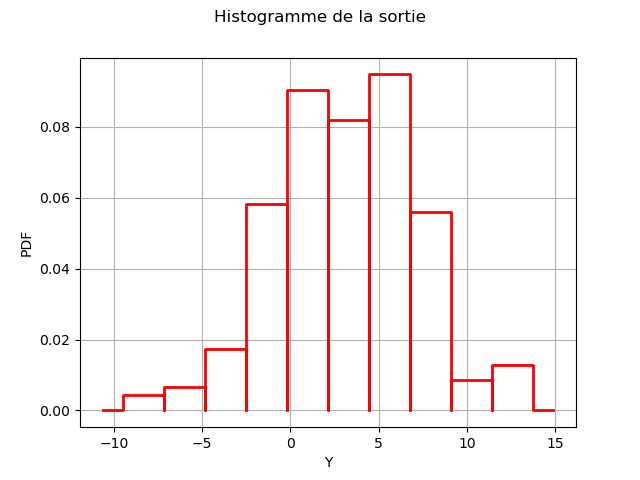

In [5]:
histo = ot.HistogramFactory().build(Y_train).drawPDF()
histo.setXTitle("Y")
histo.setTitle("Histogramme de la sortie")
histo.setLegends([""])
histo

### Création du méta-modèle

In [6]:
dimension = distribution.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.]*dimension, [1.0])
algo = ot.KrigingAlgorithm(X_train, Y_train, covarianceModel, basis)
algo.run()
result = algo.getResult()
krigeageMM = result.getMetaModel()

In [7]:
result.getTrendCoefficients()

[class=Point name=Unnamed dimension=1 values=[3.72714]]

In [8]:
result.getCovarianceModel()

class=SquaredExponential scale=class=Point name=Unnamed dimension=3 values=[1.30613,0.967255,1.27477] amplitude=class=Point name=Unnamed dimension=1 values=[22.0805]

## Validation

In [9]:
sampleSize_test = 100
X_test = distribution.getSample(sampleSize_test)
Y_test = g(X_test)

In [10]:
Y_test_MM = krigeageMM(X_test)

In [11]:
val = ot.MetaModelValidation(X_test, Y_test, krigeageMM)

In [12]:
val.computePredictivityFactor()

0.9923082887760091

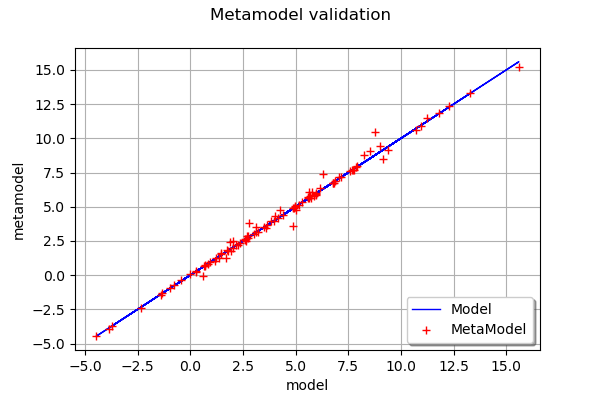

In [13]:
val.drawValidation()

## Analyse de sensibilité

In [14]:
alpha = 0.05 # i.e. 95% confidence interval
epsilon = 0.1 # Confidence interval length
blocksize = 50 # size of Sobol experiment at each iteration
batchsize = 16 # number of points evaluated simultaneously

In [15]:
estimator = ot.SaltelliSensitivityAlgorithm()
estimator.setUseAsymptoticDistribution(True)
algo = ot.SobolSimulationAlgorithm(distribution, krigeageMM, estimator)
algo.setMaximumOuterSampling(100) # number of iterations
algo.setBlockSize(blocksize) 
algo.setBatchSize(batchsize) 
algo.setIndexQuantileLevel(alpha) # alpha
algo.setIndexQuantileEpsilon(epsilon) # epsilon
algo.run()

In [16]:
result = algo.getResult()
fo = result.getFirstOrderIndicesEstimate()
to = result.getTotalOrderIndicesEstimate()
print("First order = %s" % (str(fo)))
print("Total order = %s" % (str(to)))

First order = [0.336668,0.439499,-0.00861177]
Total order = [0.584408,0.466745,0.241904]


In [17]:
def plotSobolSimulationResult(sobolSimulationResult,input_names,alpha=0.05):
    dist_fo = sobolSimulationResult.getFirstOrderIndicesDistribution()
    dist_to = sobolSimulationResult.getTotalOrderIndicesDistribution()
    dim = dist_to.getDimension()
    graph = ot.Graph("Sobol' sensivity indices","Inputs","Sensivity indices",True,"topright")
    # Indices
    curve = ot.Cloud(range(dim),fo)
    curve.setColor("red")
    curve.setLegend("First order")
    graph.add(curve)
    curve = ot.Cloud(range(dim),to)
    curve.setColor("blue")
    curve.setLegend("Total order")
    graph.add(curve)
    # Labels
    x = ot.Point(range(dim)) + ot.Point([0.1]*dim)
    text = ot.Text(x, to, input_names)
    text.setColor("black")
    graph.add(text)
    # Error bars
    for i in range(dim):
        dist_fo_i = dist_fo.getMarginal(i)
        dist_to_i = dist_to.getMarginal(i)
        fo_ci = dist_fo_i.computeBilateralConfidenceInterval(1-alpha)
        to_ci = dist_to_i.computeBilateralConfidenceInterval(1-alpha)
        fo_a = fo_ci.getLowerBound()[0]
        fo_b = fo_ci.getUpperBound()[0]
        to_a = to_ci.getLowerBound()[0]
        to_b = to_ci.getUpperBound()[0]
        curve = ot.Curve([i,i],[fo_a,fo_b])
        curve.setColor("red")
        graph.add(curve)
        curve = ot.Curve([i,i],[to_a,to_b])
        curve.setColor("blue")
        graph.add(curve)
    return graph

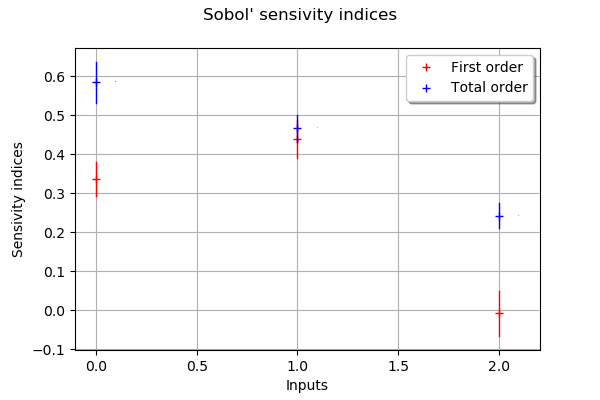

In [18]:
inputDescription = g.getInputDescription()
plotSobolSimulationResult(result,inputDescription)

- On observe que la variable $X_1$, avec un indice de Sobol' total proche de 0.6, est la variable qui possède le plus d'impact par elle même ou par ses interactions. En effet, sont indice du premier ordre est proche de 0.3, ce qui implique que les interactions entre $X_1$ et les autres variables comptent pour approximativement 30% de la variance totale. 
- La variable $X_2$ possède un indice du premier ordre proche de l'indice total, ce qui implique qu'elle n'interagit pas avec les autres variables. Son indice total est approximativement égal à 0.4. 
- La variable $X_3$ possède un indice du premier ordre proche de zéro. Elle a un impact sur la variabilité de la sortie uniquement via ses interactions avec les autres variables. 